In [ ]:
# 参数管理

In [1]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.3676],
        [-0.5706]], grad_fn=<AddmmBackward0>)

In [ ]:
# 参数访问
# 用Sequential类定义模型时，我们可以通过索引来访问模型的任意层。这就像模型是一个列表一样，每层的参数都在其属性中
print(net[2].state_dict())
print(net[1].state_dict())  # ReLU层
print(net[0].state_dict()) 
# 输出的结果告诉我们：首先，这个全连接层包含两个参数，分别是该层的权重和偏置

OrderedDict([('weight', tensor([[-0.0014, -0.2894, -0.1267,  0.2277, -0.3002, -0.3486,  0.1826, -0.2931]])), ('bias', tensor([-0.0896]))])
OrderedDict()
OrderedDict([('weight', tensor([[-0.3081,  0.1521, -0.2857,  0.4116],
        [-0.4470, -0.2286, -0.0872,  0.4462],
        [ 0.1550,  0.0468, -0.0708,  0.2740],
        [-0.2809,  0.3758,  0.3112, -0.1565],
        [-0.2020, -0.0710,  0.2685, -0.2365],
        [ 0.4956, -0.1268,  0.4279,  0.2652],
        [-0.3489,  0.0941, -0.1317, -0.4924],
        [ 0.1041,  0.1679,  0.1875, -0.1870]])), ('bias', tensor([-0.0974,  0.1127, -0.3063,  0.1085,  0.2869, -0.1131, -0.4513,  0.3848]))])


In [9]:
# 目标参数
# 每个参数都表示为参数类的一个实例。要对参数执行任何操作，首先我们需要访问底层的数值
print(type(net[2].bias))
print(net[2].bias)   # 返回参数类实例
print(net[2].bias.data)  # 访问该参数的值

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.0896], requires_grad=True)
tensor([-0.0896])


In [11]:
# 参数是符合对象，包含值、梯度和额外信息。
# 在这个网络中，由于我们还没有调用反向传播，所以参数的梯度处于初始状态
net[2].weight.grad == None  

True

In [12]:
# 一次性访问所有参数
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
# named_parameters()是PyTorch中的一个方法，用于返回模型中所有参数的名称和参数本身。它会生成一个可迭代对象，其中每个元素是(name, param)
# 列表推导式：遍历net[0]的所有参数，对于每个参数，提取其名称和形状，将名称和形状组成一个元组(name, param.shape)，最终生成一个包含所有元组的【列表】
# *是解包操作符，print(*[(a, b), (c, d)]) -> print((a, b), (c, d))
print(*[(name, param.shape) for name, param in net.named_parameters()])


('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [14]:
# 另一种访问网络参数的方式
net.state_dict()['2.bias'].data

tensor([-0.0896])

In [22]:
print(net)

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)


In [15]:
# 从嵌套块收集参数
# 让我们看看，多个块相互嵌套，参数命名约定是如何工作的。
# 首先定义一个生成块的函数（可以叫做“块工厂”）
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()   # again,这是一个容器
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block {i}', block1())  # nn.Module的一种方法，用于向一个神经网络中动态添加子模块。
                            # 第一个参数是子模块的名称（字符串）。第二个参数是要添加的模块（一个nn.Module实例）
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[0.4581],
        [0.4583]], grad_fn=<AddmmBackward0>)

In [16]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


In [17]:
# 由于层是分层嵌套的，所以我们也可以像通过嵌套列表索引一样访问它们
rgnet[0][1][0].bias.data

tensor([-0.3721, -0.1574,  0.0408, -0.0440,  0.2965,  0.0500,  0.2945,  0.2148])

In [18]:
# 参数初始化
# 默认情况下，PyTorch会根据一个范围均匀地初始化权重和偏置矩阵，这个范围是根据【输入和输出维度计算出的】
# PyTorch的nn.init模块提供了多种预置初始化方法


In [19]:
# 内置初始化
# 将所有权重参数初始化为标准差为0.01的高斯随机变量，且将偏置参数设置为0
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)   # 递归地将指定函数应用到网络中的每一层
net[0].weight.data[0], net[0].bias.data[0]


(tensor([ 0.0097, -0.0044,  0.0202, -0.0041]), tensor(0.))

In [20]:
# 还可以将所有参数初始化为给定的常数，比如初始化为1
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [23]:
# 对不同块应用不同的初始化方法。比如使用Xavier初始化方法初始化第一个神经网络层，然后将第三个神经网络层初始化为常量值42
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.3497, -0.7027, -0.3476, -0.2775])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### 自定义初始化
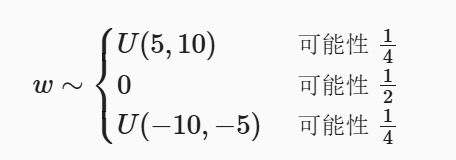

In [31]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape) for name, param in m.named_parameters()][0])   # 提取出每一层的weight
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 0.0000,  0.0000, -9.5574,  0.0000],
        [-8.8685, -5.7532, -0.0000,  7.1676]], grad_fn=<SliceBackward0>)

In [32]:
# 注意，我们始终可以直接设置参数
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  1.0000, -8.5574,  1.0000])

In [33]:
# 参数绑定：有时，我们希望在多个层之间共享参数：我们可以定义一个稠密层，然后使用它的参数来设置另一个层的参数
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)

# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们是同一个对象，而不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


In [34]:
# 注：当参数绑定时，对应层的梯度会加在一起